In [122]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pltimport 
import os, copy
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import time
import math, tqdm
import seaborn as sns
from lib.model import MLP, RNN_LSTM, RNN_ILSTM, RNN_SLSTM
from lib.data import FlatData, MNIST_add_data
from lib.utils import timeSince
from lib.train import TrainMLP, TrainRNN
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from lib.evaluation import Evaluation, plot_confusion
from lib.data import TwoStateMNISTData

In [3]:
root = './mnist_data'
if not os.path.exists(root):
    os.mkdir(root)
    
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

## multiple output

In [ ]:
from lib.model import RNN_MLP

n_hidden = 300
n_categories = 10
net = RNN_MLP(784, n_hidden, n_categories)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = TwoStateMNISTData(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

#TODO:
#trainer = TrainRNN(net, optimizer, criterion, train_data)
#trainer.train()

In [99]:
from lib.utils import pad_timeseries_tensor

a = torch.ones(25, 28, 28)
b = torch.ones(22, 28, 28)
c = torch.ones(29, 28, 28)
torch.nn.utils.rnn.pad_sequence([a,b,c]).shape

torch.Size([29, 3, 28, 28])

In [43]:
#sample n_samples correctly classified examples
def getCorrect(net, data, n_samples=100):
    xs = []
    ys = []

    i = 0
    while i < n_samples:
        d = data.next_batch(batch_size=1)
        x, y = d[0], d[1]
        output = net.eval_forward(*d)
        _, ans = torch.max(output, 1)
        if ans.item() != y.item(): # incorrect
            continue

        xs.append(x)
        ys.append(y)
        i += 1
    return xs, ys

def show_examples(net, xs, ys, n_show=3):
    for x, y in zip(xs[:n_show], ys[:n_show]):
        yhat = net.eval_forward(x, y, [len(x)])
        val, ind = torch.max(yhat, 1)
        
        n_images, _, w_h = x.shape
        print('label: %d, predict: %d, prob: %.2f' % (y.item(), ind.item(), np.exp(val.item())))
        for i in range(n_images):
            plt.subplot(1,3,i+1)
            plt.imshow(x[i].view(28,28).detach().numpy())
        plt.show()

### MLP: sanity check

In [123]:
from lib.model import MLP
net = MLP([784, 300, 10])
savename = 'models/mlp.pth.tar'
optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = FlatData(train_set)

trainer = TrainMLP(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

=> loading checkpoint 'models/mlp.pth.tar'
=> loaded checkpoint 'models/mlp.pth.tar' (iteration 3126)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss


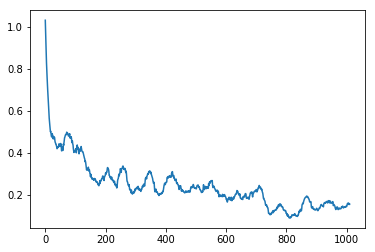

In [125]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 93.80%


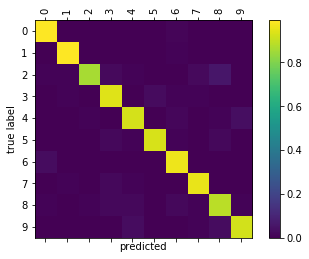

In [60]:
n_categories = 10
evaluation = Evaluation(net, FlatData(test_set))
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

# Sequence task: 1-3 mnist digits addition mod 10 (one output for seq)

### 2 layer MLP on the last step

In [126]:
from lib.model import RNN_MLP

n_hidden = 300
n_categories = 10
net = RNN_MLP(784, n_hidden, n_categories)
savename = 'models/rnn_mlp.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainRNN(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

=> loading checkpoint 'models/rnn_mlp.pth.tar'
=> loaded checkpoint 'models/rnn_mlp.pth.tar' (iteration 3101)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss


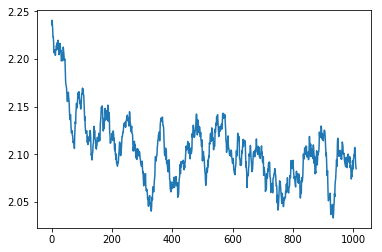

In [127]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 84.60%


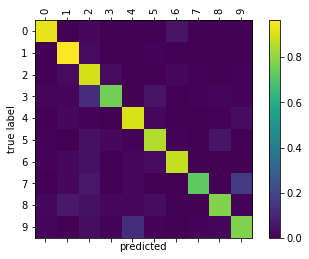

In [65]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### IMLP

In [128]:
from lib.model import RNN_IMLP

n_hidden = 300
n_categories = 10
net = RNN_IMLP(784, n_hidden, n_categories)
savename = 'models/rnn_imlp.pth.tar'
net.set_max_length(3)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainRNN(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

=> loading checkpoint 'models/rnn_imlp.pth.tar'
=> loaded checkpoint 'models/rnn_imlp.pth.tar' (iteration 3101)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss


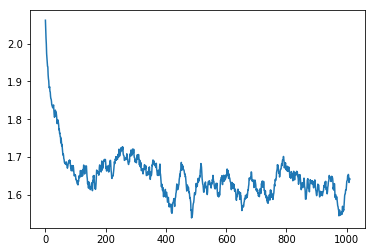

In [129]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 92.60%


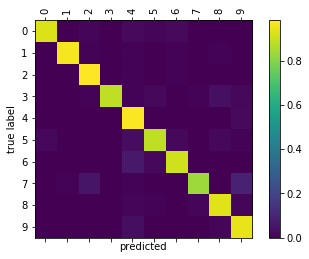

In [73]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### SMLP

In [130]:
from lib.model import RNN_SMLP

n_hidden = 300
n_categories = 10
net = RNN_SMLP(784, n_hidden, n_categories)
savename = 'models/rnn_smlp.pth.tar'
net.set_shared_groups([[0, 1], [2]])

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainRNN(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

=> loading checkpoint 'models/rnn_smlp.pth.tar'
=> loaded checkpoint 'models/rnn_smlp.pth.tar' (iteration 3101)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss


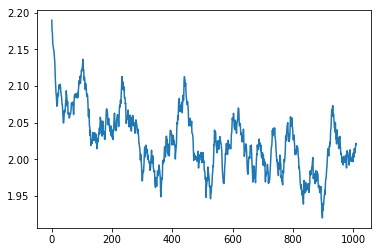

In [131]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 92.00%


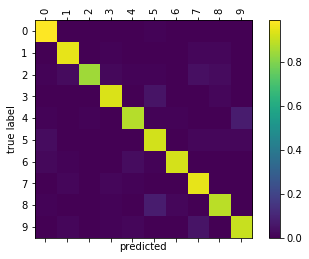

In [24]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### Independent LSTM (each time step uses an independent LSTM cell)

In [132]:
from lib.model import RNN_ILSTM

n_hidden = 300
n_categories = 10
net = RNN_ILSTM(784, n_hidden, n_categories)
savename = 'models/rnn_ilstm.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainRNN(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

=> loading checkpoint 'models/rnn_ilstm.pth.tar'
=> loaded checkpoint 'models/rnn_ilstm.pth.tar' (iteration 3101)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss


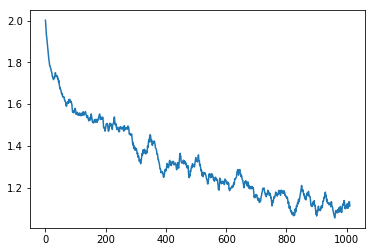

In [133]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 93.40%


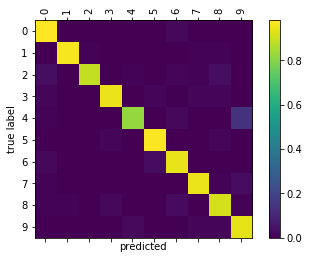

In [38]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### Staged LSTM

In [134]:
from lib.model import RNN_SLSTM

n_hidden = 300
n_categories = 10
net = RNN_SLSTM(784, n_hidden, n_categories)
savename = 'models/rnn_slstm.pth.tar'
net.set_shared_groups([[0, 1], [2]])

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainRNN(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

=> loading checkpoint 'models/rnn_slstm.pth.tar'
=> loaded checkpoint 'models/rnn_slstm.pth.tar' (iteration 3101)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss


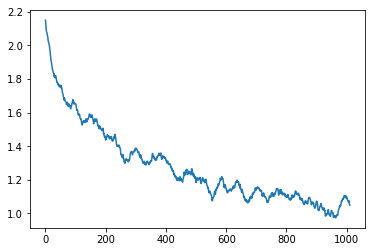

In [135]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 93.50%


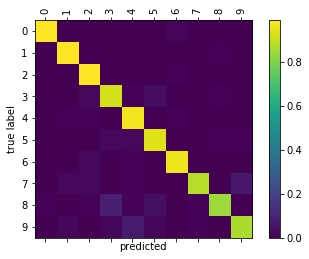

In [57]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

### LSTM

In [136]:
from lib.model import RNN_LSTM

n_hidden = 300
n_categories = 10
net = RNN_LSTM(784, n_hidden, n_categories)
savename = 'models/rnn_lstm.pth.tar'

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainRNN(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

=> loading checkpoint 'models/rnn_lstm.pth.tar'
=> loaded checkpoint 'models/rnn_lstm.pth.tar' (iteration 3126)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss


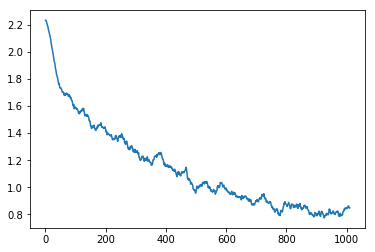

In [137]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 93.70%


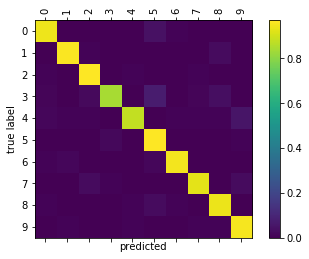

In [14]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

label: 9, predict: 9, prob: 0.70


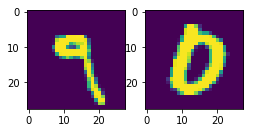

label: 6, predict: 6, prob: 0.44


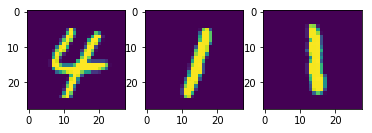

label: 8, predict: 8, prob: 0.23


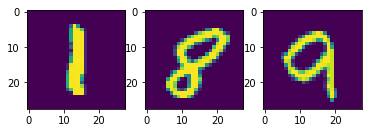

In [27]:
xs, ys = getCorrect(net, MNIST_add_data(test_set, min_length=2, max_length=3))    
show_examples(net, xs, ys)

### proposed methods: Mixture of Weights

$$W_t = \sum_{k=1}^K \lambda^{(k)}_t W^{(k)}$$ 


### lstm mow

In [138]:
from lib.model import RNN_LSTM_MoW
from lib.train import TrainMetaRNN

n_hidden = 300
n_categories = 10
net = RNN_LSTM_MoW(784, n_hidden, n_categories)
savename = 'models/rnn_lstm_mow.pth.tar'
net.setKT(2,3)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainMetaRNN(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

=> loading checkpoint 'models/rnn_lstm_mow.pth.tar'
=> loaded checkpoint 'models/rnn_lstm_mow.pth.tar' (iteration 3101)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss


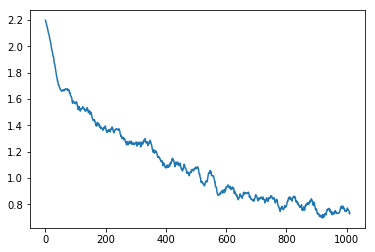

In [139]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 94.10%


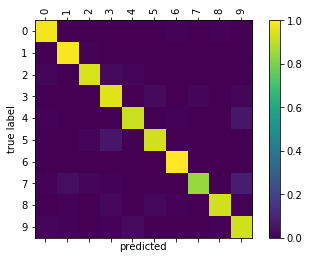

In [141]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

## mlp mow

In [140]:
from lib.model import RNN_MLP_MoW
from lib.train import TrainMetaRNN

n_hidden = 300
n_categories = 10
net = RNN_MLP_MoW(784, n_hidden, n_categories)
savename = 'models/rnn_mlp_mow.pth.tar'
net.setKT(2,3)

optimizer = torch.optim.Adam(net.parameters())
criterion = nn.NLLLoss()
train_data = MNIST_add_data(train_set)
train_data.set_seq_length(min_length=1, max_length=3)

trainer = TrainMetaRNN(net, optimizer, criterion, train_data, save_filename=savename)
if os.path.exists(savename):
    trainer.load_checkpoint(savename)
trainer.train()

=> loading checkpoint 'models/rnn_mlp_mow.pth.tar'
=> loaded checkpoint 'models/rnn_mlp_mow.pth.tar' (iteration 3101)
          #iter|       progress|     total_time|     batch_time|      data_time|       avg_loss


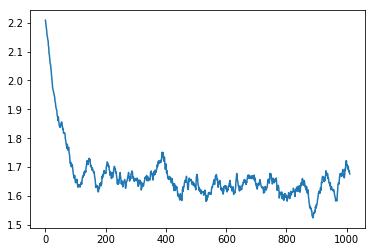

In [141]:
plt.plot(trainer.smooth_loss())
plt.show()

accuracy is 93.50%


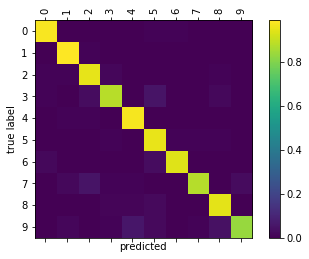

In [179]:
n_categories = 10
test_data = MNIST_add_data(test_set)
test_data.set_seq_length(min_length=1, max_length=1)

evaluation = Evaluation(net, test_data)
confusion = evaluation.confusion(n_categories, n_confusion=1000)
plot_confusion(confusion)

In [142]:
torch.nn.functional.softmax(net.coef, 1)

tensor([[0.8209, 0.1791],
        [0.3022, 0.6978],
        [0.2972, 0.7028]], grad_fn=<SoftmaxBackward>)

## Prediction tasks associated with internal states

Consider the following problem

$\mathcal{S} = \{s1, s2\}$

$\mathcal{X} = \text{MNIST Digits}$

Prediction function $f$ 

$f: x \mapsto x$ if $s=s1$

$f: x \mapsto {10-x} \pmod{10}$ if $s=s2$

State transition is **independent** of covariates at the current time step

$p(s_{t+1} = s1|s_t=s1) = p$

$p(s_{t+1} = s2|s_t=s2) = 1$

$p(s_0=s1) = 1$

In other words, we starts at state $s1$ and transition to $s2$ with probability $(1-p)$, and once we are at $s2$, we never look back.


In [222]:
p = 0.1
n_time_steps = 8

print('p=%.2f' % p)
header = ('t', 'P(s1)', 'P(s2)')
columns = []
columns.append(header)
for i in range(n_time_steps):
    columns.append((i, p**i, 1-p**i))
    
def print_table(columns):
    def format(x):
        if type(x) is float:
            x_tr = "%.3f" % x
        else:
            x_tr = str(x)
        return "%10s" % x_tr

    to_print = ""
    for r in zip(*columns):
        r = map(format, r)
        to_print += " ".join(r)
        to_print += "\n"
    print(to_print)

print_table(columns)

p=0.10
         t          0          1          2          3          4          5          6          7
     P(s1)      1.000      0.100      0.010      0.001      0.000      0.000      0.000      0.000
     P(s2)      0.000      0.900      0.990      0.999      1.000      1.000      1.000      1.000

